<참조 : https://www.tensorflow.org/tutorials/images/classification>

## Image Classification

### basic machine learning workflow
- Examine and understand data
- Build an input pipeline
- Build the model
- Train the model
- Test the model
- Improve the model and repeat the process

### 01. Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### 02. Download and explore the dataset
- imageLoad : a dataset of about 3,700 photos of flowers 데이터와 동일  
  
    
- flower_photo
  - daisy
  - dandelion
  - roses
  - sunflowers
  - tulips

In [4]:
import pathlib
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


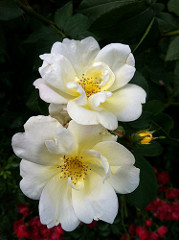

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

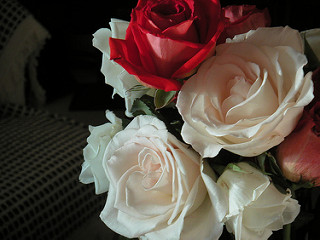

In [7]:
PIL.Image.open(str(roses[1]))

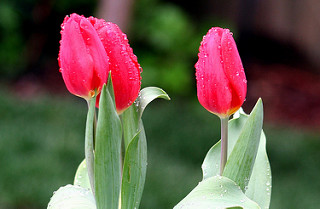

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

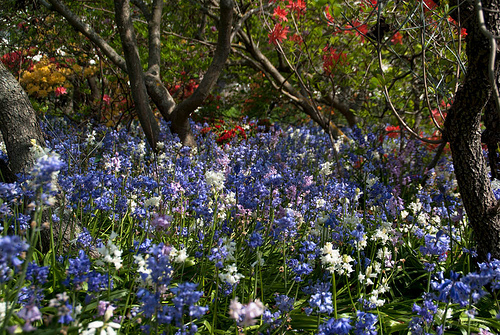

In [9]:
PIL.Image.open(str(tulips[1]))

### 03. Create a Dataset

In [10]:
batch_size = 32
img_height = 180
img_width = 180

- a validation split
  - training data : 80%
  - validataion data : 20%

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 04. Visualize the data

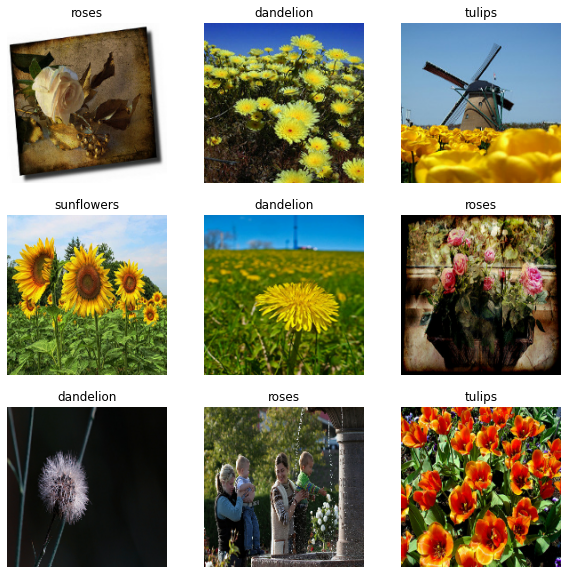

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### 05. Configure the dataset for performance
- Dataset.cache() : keeps the images in memory after they're loaded off disk during the first epoch.
- Dataset.prefetch() : overlaps data preprocessing and model execution while training

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

1.2155514e-06 0.97717154


### 06. Create the model

In [22]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### 07. Compile and Train the model

In [23]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [25]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 254s 3s/step - loss: 1.3995 - accuracy: 0.3992 - val_loss: 1.1726 - val_accuracy: 0.5245
Epoch 2/10
92/92 [==============================] - 201s 2s/step - loss: 1.0735 - accuracy: 0.5739 - val_loss: 1.0231 - val_accuracy: 0.5926
Epoch 3/10
92/92 [==============================] - 225s 2s/step - loss: 0.9225 - accuracy: 0.6356 - val_loss: 0.9418 - val_accuracy: 0.6335
Epoch 4/10
92/92 [==============================] - 243s 3s/step - loss: 0.7333 - accuracy: 0.7231 - val_loss: 0.8794 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 240s 3s/step - loss: 0.5590 - accuracy: 0.7878 - val_loss: 0.9653 - val_accuracy: 0.6444
Epoch 6/10
92/92 [==============================] - 235s 3s/step - loss: 0.3538 - accuracy: 0.8798 - val_loss: 1.0678 - val_accuracy: 0.6485
Epoch 7/10
92/92 [==============================] - 232s 3s/step - loss: 0.1943 - accuracy: 0.9401 - val_loss: 1.1935 - val_accuracy: 0.6417
Epoch 8/10
92

### 08. Visualize training results

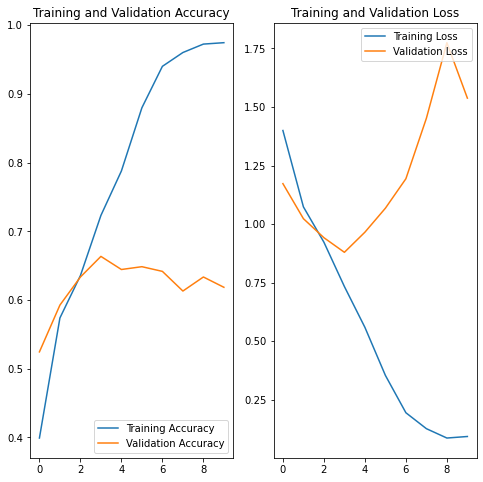

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 09. Overfitting / Data Augmentation
- Overfitting 
  - 훈련 정확성과 검증 정확성의 차이가 커지는 현상 : 과대적합(overfitting)의 징후
  - 훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습 : 과대적합

#### 09. 01. Data Augmentation
  - 데이터를 증강한 다음 이미지를 생성하는 임의 변환을 사용
  - 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다
  - keras 전처리 레이어를 사용하여 데이터 증강 구현

In [27]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                        input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

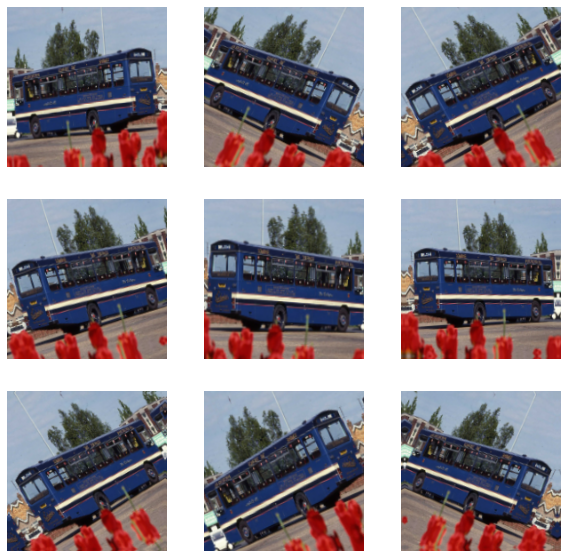

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

#### 09. 02. Dropout
- 레이어에 적용하면 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃

In [29]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### 10. Compile and Train the model

In [30]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [32]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 281s 3s/step - loss: 1.2951 - accuracy: 0.4377 - val_loss: 1.0918 - val_accuracy: 0.5599
Epoch 2/15
92/92 [==============================] - 261s 3s/step - loss: 1.0379 - accuracy: 0.5920 - val_loss: 0.9779 - val_accuracy: 0.6213
Epoch 3/15
92/92 [==============================] - 254s 3s/step - loss: 0.9255 - accuracy: 0.6264 - val_loss: 0.8717 - val_accuracy: 0.6662
Epoch 4/15
92/92 [==============================] - 254s 3s/step - loss: 0.8219 - accuracy: 0.6843 - val_loss: 0.8415 - val_accuracy: 0.6662
Epoch 5/15
92/92 [==============================] - 255s 3s/step - loss: 0.7888 - accuracy: 0.7030 - val_loss: 0.8748 - val_accuracy: 0.6540
Epoch 6/15
92/92 [==============================] - 256s 3s/step - loss: 0.7467 - accuracy: 0.7193 - val_loss: 0.7846 - val_accuracy: 0.6866
Epoch 7/15
92/92 [==============================] - 256s 3s/step - loss: 0.7083 - accuracy: 0.7221 - val_loss: 0.7931 - val_accuracy: 0.6771
Epoch 8/15
92

### 11. Viusalize training results
- Data Augmentaion / Dropout

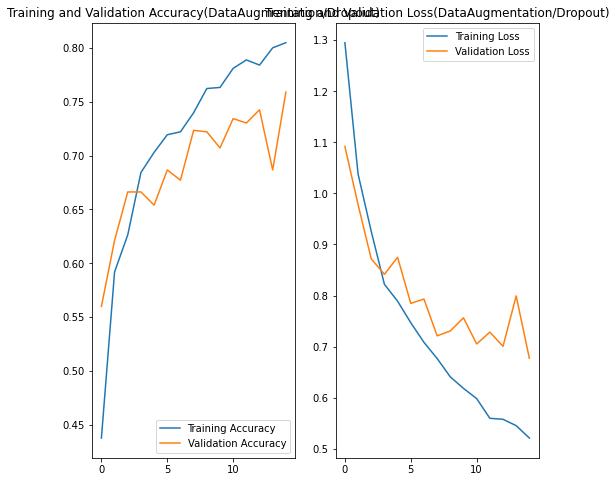

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy(DataAugmentation/Dropout)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss(DataAugmentation/Dropout)')
plt.show()

### 12. Predict on new data

In [36]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('Red_sunflow', origin=sunflower_url)

img = keras.preprocessing.image.load_img(sunflower_path,
                                        target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)    # Create a betch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    'This image most likely belongs to {} with a {:.2f} percent confidence'
    .format(class_names[np.argmax(score)], 100*np.max(score))
)

131072/117948 [=================================] - 0s 1us/step
This image most likely belongs to sunflowers with a 99.75 percent confidence


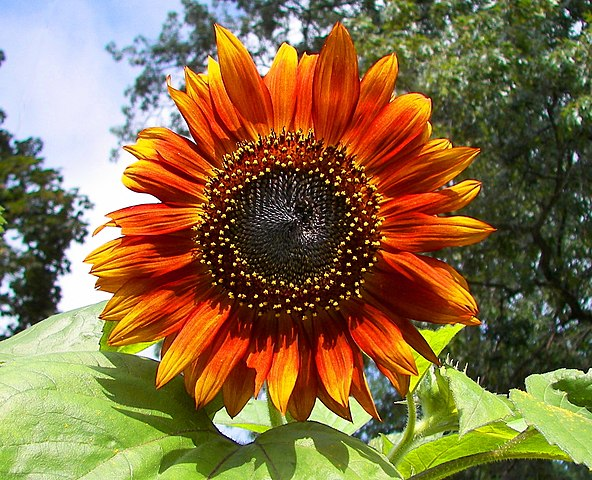